### Compute topological barcodes using IMS position tracking

- Author: Zachary Neronha
- Last Modified: Nov 25 (Dhananjay Bhaskar)

In [1]:
library(TDA)
library(grid)
library(repr)
library(pracma)
library(stringr)
library(extrafont)
library(latex2exp)

library("ripserr")
library("graphics")
library("ggplot2")
library("scatterplot3d")

loadfonts(quiet = TRUE)
loadfonts(device = "postscript", quiet = TRUE)

names(postscriptFonts())

Registering fonts with R
Welcome to ripserr.


[1] "serif"                      "sans"                      
 [3] "mono"                       "AvantGarde"                
 [5] "Bookman"                    "Courier"                   
 [7] "Helvetica"                  "Helvetica-Narrow"          
 [9] "NewCenturySchoolbook"       "Palatino"                  
[11] "Times"                      "URWGothic"                 
[13] "URWBookman"                 "NimbusMon"                 
[15] "NimbusSan"                  "URWHelvetica"              
[17] "NimbusSanCond"              "CenturySch"                
[19] "URWPalladio"                "NimbusRom"                 
[21] "URWTimes"                   "ArialMT"                   
[23] "ComputerModern"             "ComputerModernItalic"      
[25] "Japan1"                     "Japan1HeiMin"              
[27] "Japan1GothicBBB"            "Japan1Ryumin"              
[29] "Korea1"                     "Korea1deb"                 
[31] "CNS1"                       "GB1"                       
[33] "Amiri"                      "Amiri Quran"               
[35] "Carlito"                    "DejaVu Sans"               
[37] "DejaVu Sans Condensed"      "DejaVu Sans Light"         
[39] "DejaVu Sans Mono"           "DejaVu Serif"              
[41] "DejaVu Serif Condensed"     "EB Garamond 08"            
[43] "EB Garamond 08 SC"          "EB Garamond 12"            
[45] "EB Garamond Initials Fill1" "EB Garamond Initials Fill2"
[47] "FontAwesome"                "FreeMono"                  
[49] "FreeSans"                   "FreeSerif"                 
[51] "Gentium"                    "GentiumAlt"                
[53] "Gentium Basic"              "Gentium Book Basic"        
[55] "Gentium Plus"               "IPAexGothic"               
[57] "IPAexMincho"                "IPAGothic"                 
[59] "IPAMincho"                  "IPAPGothic"                
[61] "IPAPMincho"                 "Junicode"                  
[63] "Lato Black"                 "Lato"                      
[65] "Lato Hairline"              "Lato Heavy"                
[67] "Lato Light"                 "Lato Medium"               
[69] "Lato Semibold"              "Lato Thin"                 
[71] "Liberation Mono"            "Liberation Sans"           
[73] "Liberation Sans Narrow"     "Liberation Serif"          
[75] "Myriad Pro"                 "CM Roman"                  
[77] "CM Roman Asian"             "CM Roman CE"               
[79] "CM Roman Cyrillic"          "CM Roman Greek"            
[81] "CM Sans"                    "CM Sans Asian"             
[83] "CM Sans CE"                 "CM Sans Cyrillic"          
[85] "CM Sans Greek"              "CM Symbol"                 
[87] "CM Typewriter"              "CM Typewriter Asian"       
[89] "CM Typewriter CE"           "CM Typewriter Cyrillic"    
[91] "CM Typewriter Greek"

#### Ripser loading and binding

In [2]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames( diagram ) = c( "dimension" , "Birth" , "Death" )
    
    return( diagram )    
}

## Calculate rips diagram using Ripser library
ripserDiag = function( X, dimension, threshold, format = "point-cloud" ){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/labmember/ripser/ripser", args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), stdout = TRUE)
    
    return( parseOutput( ripserOut ) )
}

#### Custom plotting functions

In [3]:
px2um = 1.0

dim0barcode = function(dimintervals, max_x_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0, 1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    g = g + geom_point(aes(x = bmat, y = ymat), color = "darkblue", size = 2.25)
    g = g + geom_point(aes(x = dmat, y = ymat), color = "darkblue", size = 2.25)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat), 
                         color = "darkblue", size = 1.25)
    
    # last connected component
    g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 2.25)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")),
                         color = "darkblue", size = 1.25)
    
    g = g + ylab(TeX('$\\beta_0$')) + xlab(TeX('$\\epsilon$ ($\\mu m$)'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 23, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 20, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2))
    return(g)
    
}

dim1barcode = function(dimintervals, x_min_lim, x_max_lim){
    
    numintervals = dim(dimintervals)[1]
    ymat = linspace(0,1, n = numintervals + 1)
    y_end = ymat[length(ymat)]
    ymat = ymat[1:length(ymat)-1]
    
    g = ggplot()
    
    bmat = px2um * dimintervals[,2]
    dmat = px2um * dimintervals[,3]
    
    g = g + geom_point(aes(x = bmat, y = ymat), color = 'red', size = 2.25)
    g = g + geom_point(aes(x = dmat, y = ymat), color = 'red', size = 2.25)
    g = g + geom_segment(aes(x = bmat, y = ymat, xend = dmat, yend = ymat),
                         color = 'red', size = 1.25)
    
    g = g + ylab(TeX('$\\beta_1$')) + xlab(TeX('$\\epsilon$ ($\\mu m$)'))
    g = g + xlim(x_min_lim, x_max_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 23, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 20, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2))
    return(g)
    
}

combinedbarcode = function(dim0intervals, dim1intervals, max_x_lim){
    
    numintervals_b0 = dim(dim0intervals)[1]
    numintervals_b1 = dim(dim1intervals)[1]
    
    ymat = linspace(0, 1, n = (numintervals_b0 + numintervals_b1 + 1))
    
    y_end = ymat[length(ymat)]
    ymat1 = ymat[1:numintervals_b1]
    ymat0 = ymat[(numintervals_b1+1):(length(ymat)-1)]
    
    g = ggplot()
    
    if (numintervals_b1 > 0){
        b1mat = px2um * dim1intervals[,2]
        d1mat = px2um * dim1intervals[,3]

        g = g + geom_point(aes(x = b1mat, y = ymat1), color = 'red', size = 2.25)
        g = g + geom_point(aes(x = d1mat, y = ymat1), color = 'red', size = 2.25)
        g = g + geom_segment(aes(x = b1mat, y = ymat1, xend = d1mat, yend = ymat1), 
                             color = 'red', size = 1.25)
    }
    
    b0mat = px2um * dim0intervals[,2]
    d0mat = px2um * dim0intervals[,3]
    
    g = g + geom_point(aes(x = b0mat, y = ymat0), color = "darkblue", size = 2.25)
    g = g + geom_point(aes(x = d0mat, y = ymat0), color = "darkblue", size = 2.25)
    g = g + geom_segment(aes(x = b0mat, y = ymat0, xend = d0mat, yend = ymat0), 
                         color = "darkblue", size = 1.25)
    
    # last connected component
    g = g + geom_point(aes(x = 0, y = y_end), color = "darkblue", size = 2.5)
    g = g + geom_segment(aes(x = 0, y = y_end, xend = max_x_lim, yend = y_end), 
                         arrow = arrow(type = "open", angle = 30, length = unit(0.2, "cm")), 
                         color = "darkblue", size = 1.25)
    
    g = g + ylab(TeX('Barcode ($\\beta_0$, $\\beta_1$)')) + xlab(TeX('$\\epsilon$ ($\\mu m$)'))
    g = g + xlim(0, max_x_lim) + ylim(-0.1, 1.1) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                 text = element_text(colour = "black", size = 23, family = "Myriad Pro"), 
                 axis.text.x = element_text(colour = "black", size = 20, family = "Myriad Pro"))
    g = g + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2))
    return(g)
    
}

persistencediag = function(dim0intervals, dim1intervals, x_max_lim){
    
    g = ggplot()
    
    beta0_bmat = px2um * dim0intervals[,2]
    beta0_dmat = px2um * dim0intervals[,3]
    
    beta1_bmat = px2um * dim1intervals[,2]
    beta1_dmat = px2um * dim1intervals[,3]
    
    g = g + geom_point(aes(x = beta0_bmat, y = beta0_dmat), 
                       color = "darkblue", shape = 1, alpha = 1.0, size = 2.5, stroke = 1.5)
    g = g + geom_point(aes(x = beta1_bmat, y = beta1_dmat), 
                       color = "red", shape = 2, alpha = 1.0, size = 2.5, stroke = 1.5)
    g = g + geom_segment(aes(x = 0, y = 0, xend = x_max_lim, yend = x_max_lim), 
                       color = 'black', size = 1.25)
    
    g = g + ylab("Interval End") + xlab("Interval Start")
    g = g + xlim(0, x_max_lim) + ylim(0, x_max_lim) + theme_bw()
    g = g + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                text = element_text(colour = "black", size = 23, family = "Myriad Pro"),
                axis.text.x = element_text(colour = "black", size = 20, family = "Myriad Pro"), 
                axis.text.y = element_text(colour = "black", size = 20, family = "Myriad Pro"))
    g = g + theme(legend.position = "none", panel.border = element_rect(colour = "black", fill = NA, size = 2)) 
    return(g)
    
}

saveepsfig = function(p, w, h, t, fontfamily, fname){
    
    postscript(fname, family = fontfamily, width = w, height = h, title = t)
    p
    dev.off()
    embed_fonts(fname, outfile = fname)
    
}

#### Calculate Betti numbers for well A07 (Epithelial)

In [4]:
datU = read.csv('Wk2_IMS_Crop_Tracks/3d sc xmas 9-20-18 week 2_A07_spots17_Statistics/A07.csv', header = FALSE)
code = data.matrix(datU)

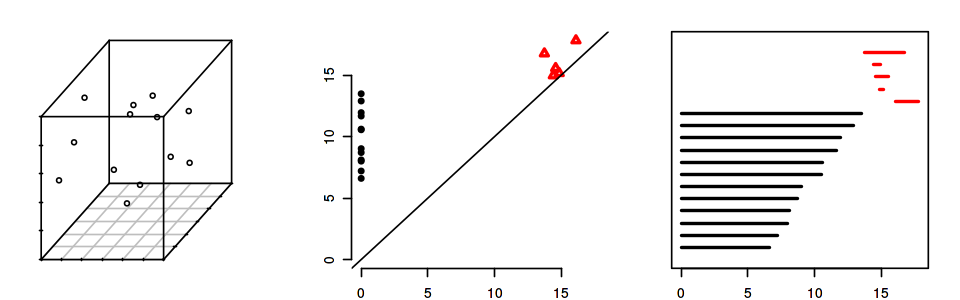

In [5]:
homology2_code <- ripserDiag(code, 2, 500)
intervals = as.data.frame(homology2_code)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=8,repr.plot.height=2.5)

scatterplot3d(code, y=NULL, z=NULL, xlab="", ylab="", zlab="", label.tick.marks=FALSE, mar=c(2,2,2,2))
TDA::plot.diagram(homology2_code, barcode = FALSE)
TDA::plot.diagram(homology2_code, barcode = TRUE)

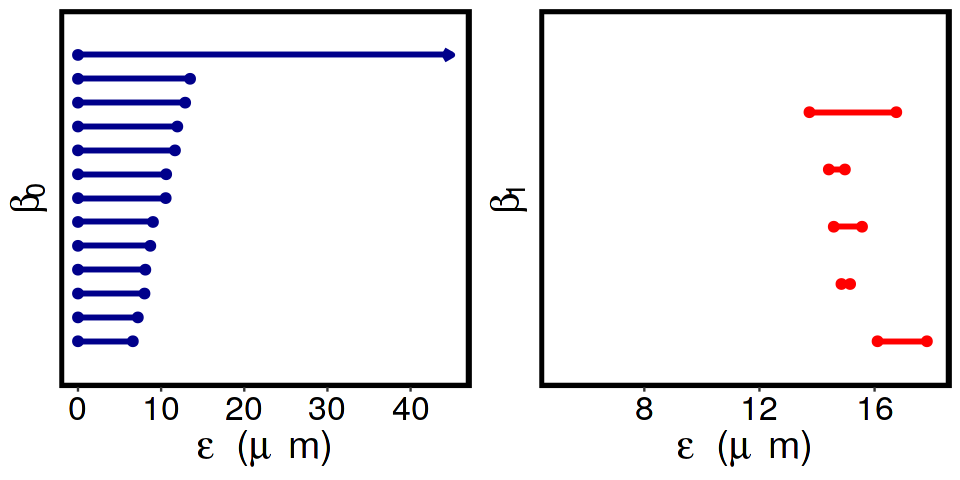

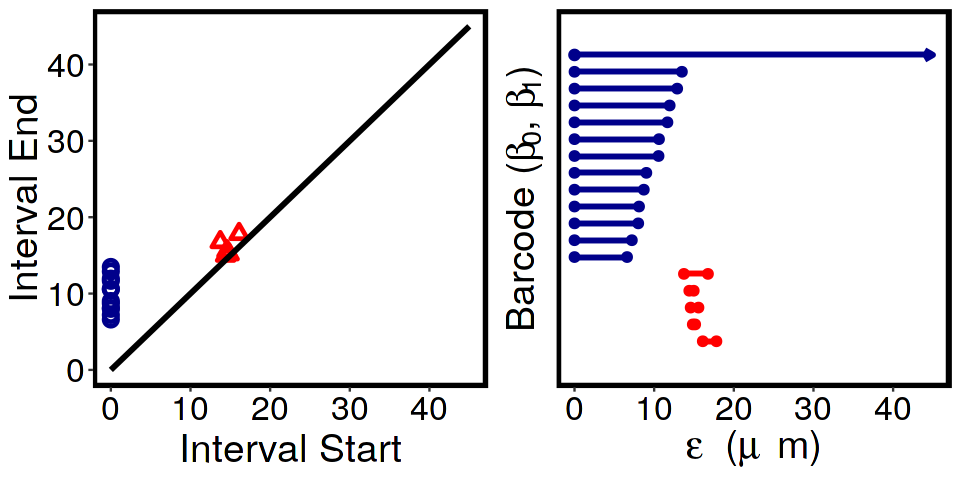

In [6]:
p1 = dim0barcode(dim0, 45)
p2 = dim1barcode(dim1, 5, 18)
p3 = persistencediag(dim0, dim1, 45)
p4 = combinedbarcode(dim0, dim1, 45)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

In [7]:
saveepsfig(p1, 4.4, 4.4, "A07 Epithelial Betti 0", "Myriad Pro", "A07_Epithelial_Betti0.eps")
saveepsfig(p2, 4.4, 4.4, "A07 Epithelial Betti 1", "Myriad Pro", "A07_Epithelial_Betti1.eps")
saveepsfig(p3, 4.4, 4.4, "A07 Epithelial Persistence Diagram", "Myriad Pro", "A07_Epithelial_PersistencePlot.eps")
saveepsfig(p4, 4.4, 4.4, "A07 Epithelial Barcode", "Myriad Pro", "A07_Epithelial_Barcode.eps")

#### Calculate Betti numbers for well A08

In [33]:
datU = read.csv('Wk2_IMS_Crop_Tracks/3d sc xmas 9-20-18 week 2_A08_spots2_Statistics/A08.csv',header=FALSE)
code = data.matrix(datU)

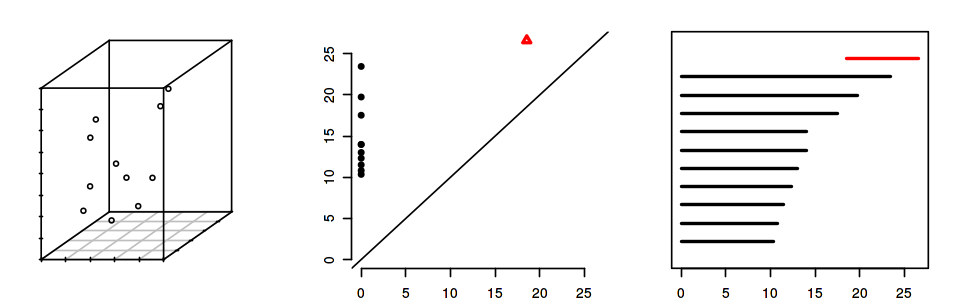

In [34]:
homology2_code <- ripserDiag(code, 2, 500)

intervals = as.data.frame(homology2_code)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width = 8, repr.plot.height = 2.5)

scatterplot3d(code, y=NULL, z=NULL, xlab="", ylab="", zlab="", label.tick.marks=FALSE, mar=c(2,2,2,2))
TDA::plot.diagram(homology2_code, barcode = FALSE)
TDA::plot.diagram(homology2_code, barcode = TRUE)

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_segment).”

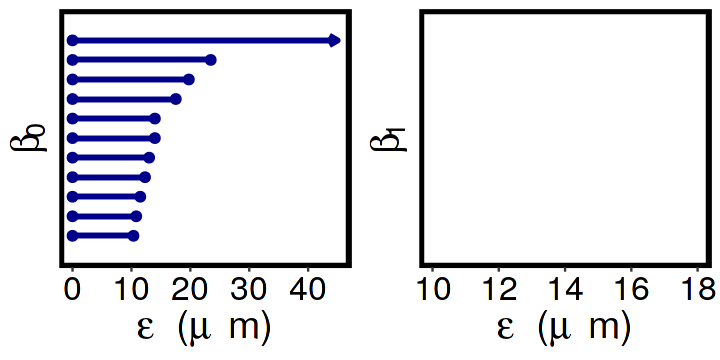

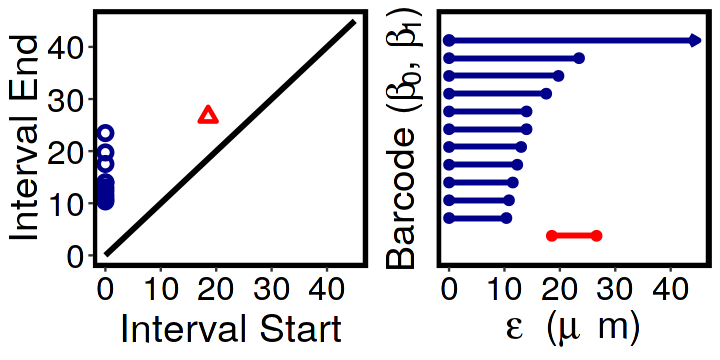

In [35]:
p1 = dim0barcode(dim0, 45)
p2 = dim1barcode(dim1, 10, 18)
p3 = persistencediag(dim0, dim1, 45)
p4 = combinedbarcode(dim0, dim1, 45)

options(repr.plot.width = 6, repr.plot.height = 3)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

#### Calculate Betti numbers for well A12 (mesenchymal)

In [36]:
# Load the data from the spreadsheet
datU = read.csv('Wk2_IMS_Crop_Tracks/3d sc xmas 9-20-18 week 2_A12_spots15_Statistics/A12.csv',header=FALSE)
code = data.matrix(datU)

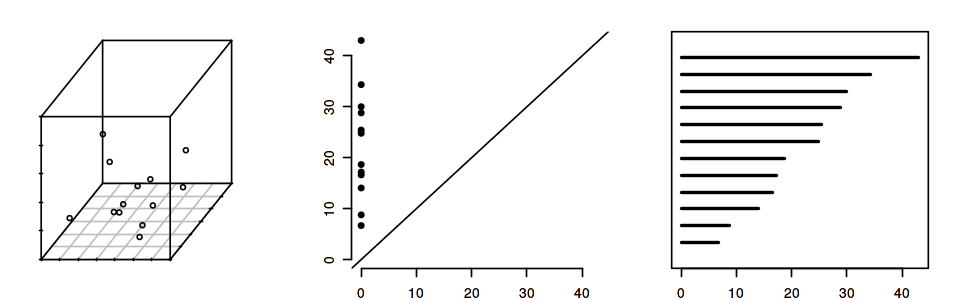

In [37]:
homology2_code <- ripserDiag(code, 2, 500)

intervals = as.data.frame(homology2_code)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width = 8, repr.plot.height = 2.5)

scatterplot3d(code, y=NULL, z=NULL, xlab="", ylab="", zlab="", label.tick.marks = FALSE, mar = c(2,2,2,2))
TDA::plot.diagram(homology2_code, barcode = FALSE)
TDA::plot.diagram(homology2_code, barcode = TRUE)

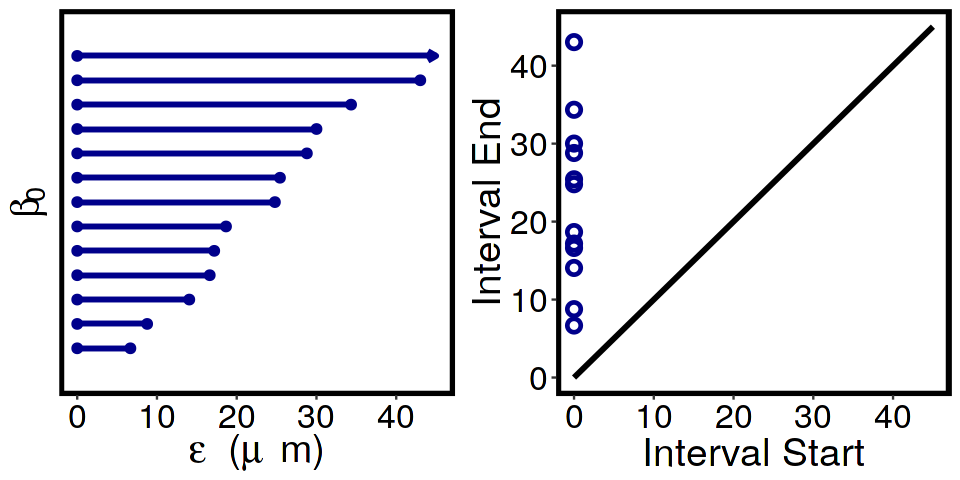

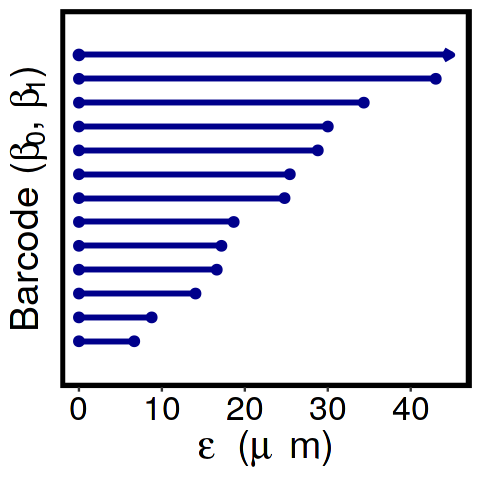

In [38]:
p1 = dim0barcode(dim0, 45)
p3 = persistencediag(dim0, dim1, 45)
p4 = combinedbarcode(dim0, dim1, 45)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p3), size = "last"))

options(repr.plot.width = 4, repr.plot.height = 4)
print(p4)

In [105]:
ggsave("A12_Mesenchymal_Betti0.eps", p1, width = 4.4, height = 4.4)
ggsave("A12_Mesenchymal_PersistencePlot.eps", p3, width = 4.4, height = 4.4)
ggsave("A12_Mesenchymal_Barcode.eps", p4, width = 4.4, height = 4.4)

#### Calculate Betti numbers for well B10 (pEMT)

In [106]:
# Load the data from the spreadsheet
datU = read.csv('Wk2_IMS_Crop_Tracks/3d sc xmas 9-20-18 week 2_B10_spot11_Statistics/B10.csv',header=FALSE)
code = data.matrix(datU)

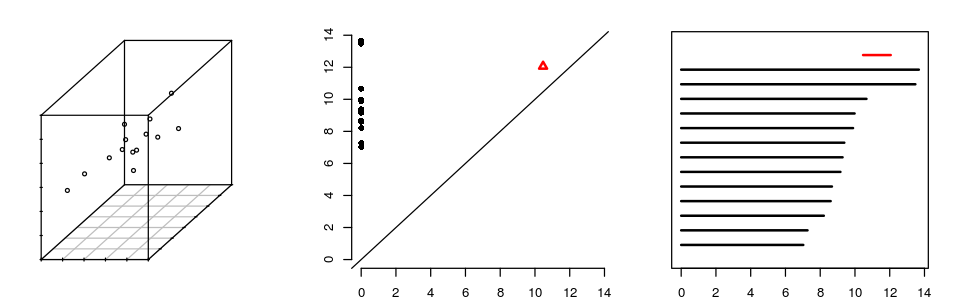

In [107]:
homology2_code <- ripserDiag(code, 2, 500)

intervals = as.data.frame(homology2_code)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

par(mfrow = c(1, 3), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width = 8, repr.plot.height = 2.5)

scatterplot3d(code, y=NULL, z=NULL, xlab="", ylab="", zlab="", label.tick.marks = FALSE, mar = c(2,2,2,2))
TDA::plot.diagram(homology2_code, barcode = FALSE)
TDA::plot.diagram(homology2_code, barcode = TRUE)

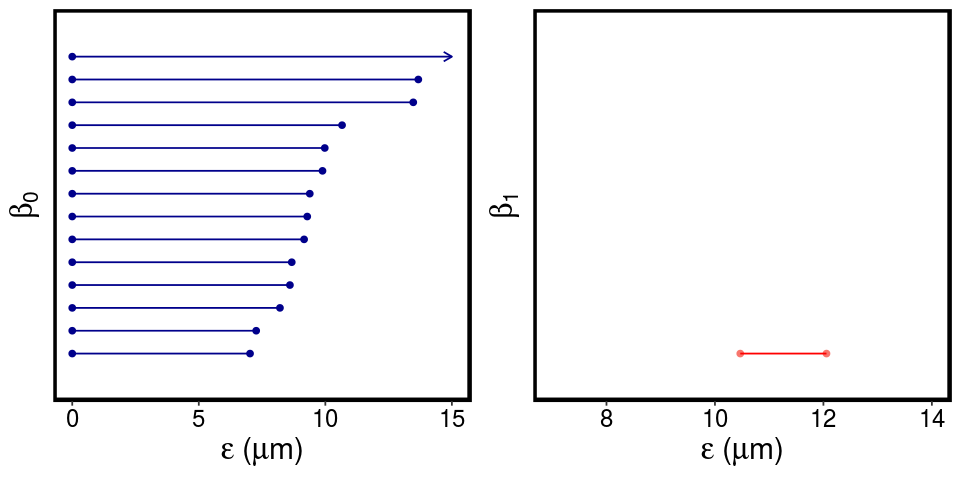

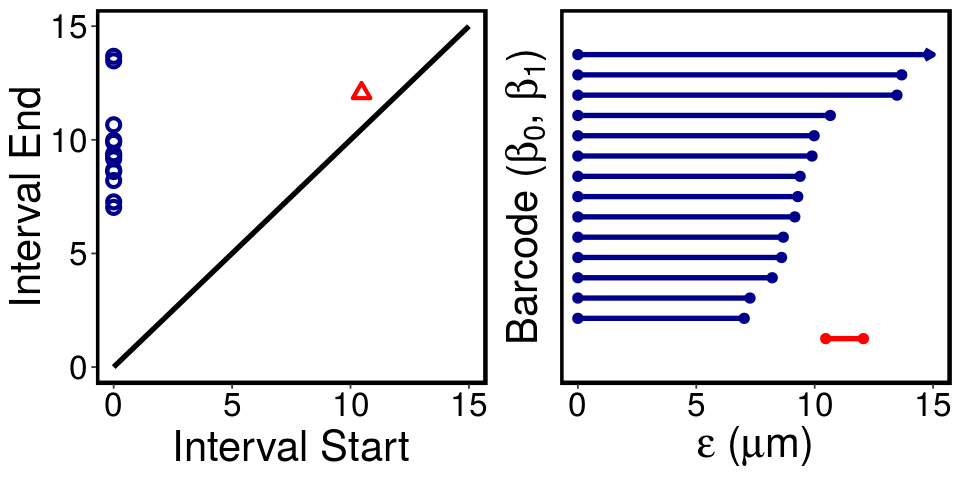

In [112]:
p1 = dim0barcode(dim0, 15)
p2 = dim1barcode(dim1, 7, 14)
p3 = persistencediag(dim0, dim1, 15)
p4 = combinedbarcode(dim0, dim1, 15)

options(repr.plot.width = 8, repr.plot.height = 4)
grid.newpage()
grid.draw(cbind(ggplotGrob(p1), ggplotGrob(p2), size = "last"))
grid.newpage()
grid.draw(cbind(ggplotGrob(p3), ggplotGrob(p4), size = "last"))

In [113]:
ggsave("B10_pEMT_Betti0.eps", p1, width = 4.4, height = 4.4)
ggsave("B10_pEMT_Betti1.eps", p2, width = 4.4, height = 4.4)
ggsave("B10_pEMT_PersistencePlot.eps", p3, width = 4.4, height = 4.4)
ggsave("B10_pEMT_Barcode.eps", p4, width = 4.4, height = 4.4)